Run in a seperate env, scratch_conda_env. I wanted to avoid installing new packages to perch_conda_env in case it breaks.

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from IPython.display import display
from pathlib import Path
import warnings
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from astral.sun import sun
from astral import LocationInfo
import pytz

In [13]:
#@title Set Paths
base_dir = os.getenv('BASE_DIR')
if not base_dir:
    raise ValueError("BASE_DIR environment variable is not set.")

In [14]:
# Select country
COUNTRY = 'indonesia'

### Store raw files lists
We use this to calculate statistics, e.g get total count of days per site

In [15]:
# Folder containing audio files
audio_dir = Path("/media/mars_5tb_drive/mars_global_acoustic_study/" + COUNTRY + "_acoustics/raw_audio")

# Output CSV path
raw_file_list = os.path.join(base_dir, "marrs_acoustics/data/output_dir_" + COUNTRY + "/raw_file_list.csv")

# Collect all .wav and .WAV files
file_list = [f for f in os.listdir(audio_dir) if f.lower().endswith('.wav')]

# Save the list to a CSV file
file_list_df = pd.DataFrame(file_list, columns=["filename"])
file_list_df.to_csv(raw_file_list, index=False)

print(f"File list saved to {raw_file_list}")


File list saved to /home/bwilliams/ucl_projects/marrs_acoustics/data/output_dir_indonesia/raw_file_list.csv


### Calculate total recording time on each site
Note, each recorder was on a duty cycle of one in two min. So if a recorder has a total of 10 days, that means it collected 10 days of total audio across a 20 day period.

In [16]:
# Extract the 'site name' from the filename (15th and 16th characters)
file_list_df['site_name'] = file_list_df['filename'].str[4:6]

# Count the number of files (minutes of audio) per site
minutes_per_site = file_list_df['site_name'].value_counts().sort_index()

# Convert minutes to days (1440 minutes in a day)
days_per_site = minutes_per_site / 1440

# Convert to DataFrames for full display in Jupyter
minutes_per_site_df = minutes_per_site.reset_index(name="Minutes")
days_per_site_df = days_per_site.reset_index(name="Days")

# Display in list format in Jupyter
print("Minutes of audio per site:")
display(minutes_per_site_df)

print("\nDays of audio per site:")
display(days_per_site_df)


Minutes of audio per site:


,site_name,Minutes
0,D1,15575
1,D2,15138
2,D3,15229
3,D4,15049
4,D5,17578
5,D6,15045
6,H1,15960
7,H2,15628
8,H3,16377
9,H4,3270



Days of audio per site:


,site_name,Days
0,D1,10.815972
1,D2,10.512500
2,D3,10.575694
3,D4,10.450694
4,D5,12.206944
5,D6,10.447917
6,H1,11.083333
7,H2,10.852778
8,H3,11.372917
9,H4,2.270833


### Plot individual sounds
Will plot the mean count per day of 5sec periods that contain the target sound.
As the recorders were on a duty cycle of one in two minutes, we double all counts.

Start by prepping a df

In [86]:
# Set target sound and the duty cycle
TARGET_SOUND = 'rattle'
DUTY_CYCLE = 2

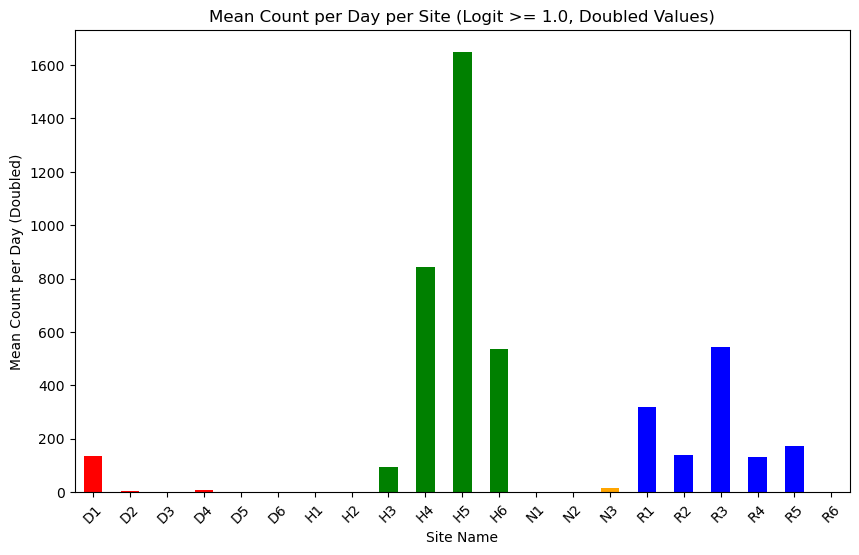

In [87]:
# Load the CSV file
inference_csv = os.path.join(base_dir, f'marrs_acoustics/data/output_dir_{COUNTRY}/agile_outputs/{TARGET_SOUND}/{TARGET_SOUND}_inference.csv')
inference_df = pd.read_csv(inference_csv)

# Remove leading and trailing spaces from column names
inference_df.columns = inference_df.columns.str.strip()

# Filter rows where 'logit' is 1.0 or higher
filtered_df = inference_df[inference_df['logit'] >= 1.0]

# Extract 'site name' from the 'filename' column (15th and 16th characters)
filtered_df['site_name'] = filtered_df['filename'].str[14:16]

# Count occurrences of each site and sort by site name alphabetically
site_counts = filtered_df['site_name'].value_counts().sort_index()

# Get days of audio per site (from previous code)
days_per_site = minutes_per_site / 1440

# Calculate mean count per day for each site
mean_count_per_day = site_counts / days_per_site

# Double the values for each bar to visualise a higher scale
mean_count_per_day *= DUTY_CYCLE  # Doubling each value as requested

# Define colours based on the starting letter of each site name
colours = mean_count_per_day.index.map(lambda site: 
    'red' if site.startswith('D') else
    'green' if site.startswith('H') else
    'orange' if site.startswith('N') else
    'blue' if site.startswith('R') else 'grey'  # Default to grey if none of the specified letters match
)

# Plotting
plt.figure(figsize=(10, 6))
mean_count_per_day.plot(kind='bar', color=colours)
plt.title("Mean Count per Day per Site (Logit >= 1.0, Doubled Values)")
plt.xlabel("Site Name")
plt.ylabel("Mean Count per Day (Doubled)")
plt.xticks(rotation=45)

# Define the save path and create directories if they do not exist
save_dir = os.path.join(base_dir, 'marrs_acoustics/data/results/' + COUNTRY + '/barplots')
os.makedirs(save_dir, exist_ok=True) 

# Save the plot
save_path = os.path.join(save_dir, f"{TARGET_SOUND}.png")
plt.savefig(save_path)

plt.show()


TODO: 
1. get actual sunrise and sunset times, currently uses 6am and 6pm
2. Plot all sites (sometimes a newly restores is missing for example), and make sure it only plots up to the date the site recorded to (looking at newly restored again)
3. use the raw file list csv to set time bound
4. use or merge colour codes in cell above
5. tidy up axis etc
6. Now make a mean 24hr rose plot or fairbrass type plot, make sure this ignores days with no data otherwise it will pull the avg down.
7. Add the part where no audio was taken as batteries died (as above, block out periods where no data is present)
8. double the count per hour/add the duty cycle thing

In [88]:
# Set location and timezone, some moths were on local time some were on UK
latitude, longitude = -4.92913, 119.3175
location = LocationInfo(latitude=latitude, longitude=longitude)
local_timezone = pytz.timezone("Asia/Makassar")

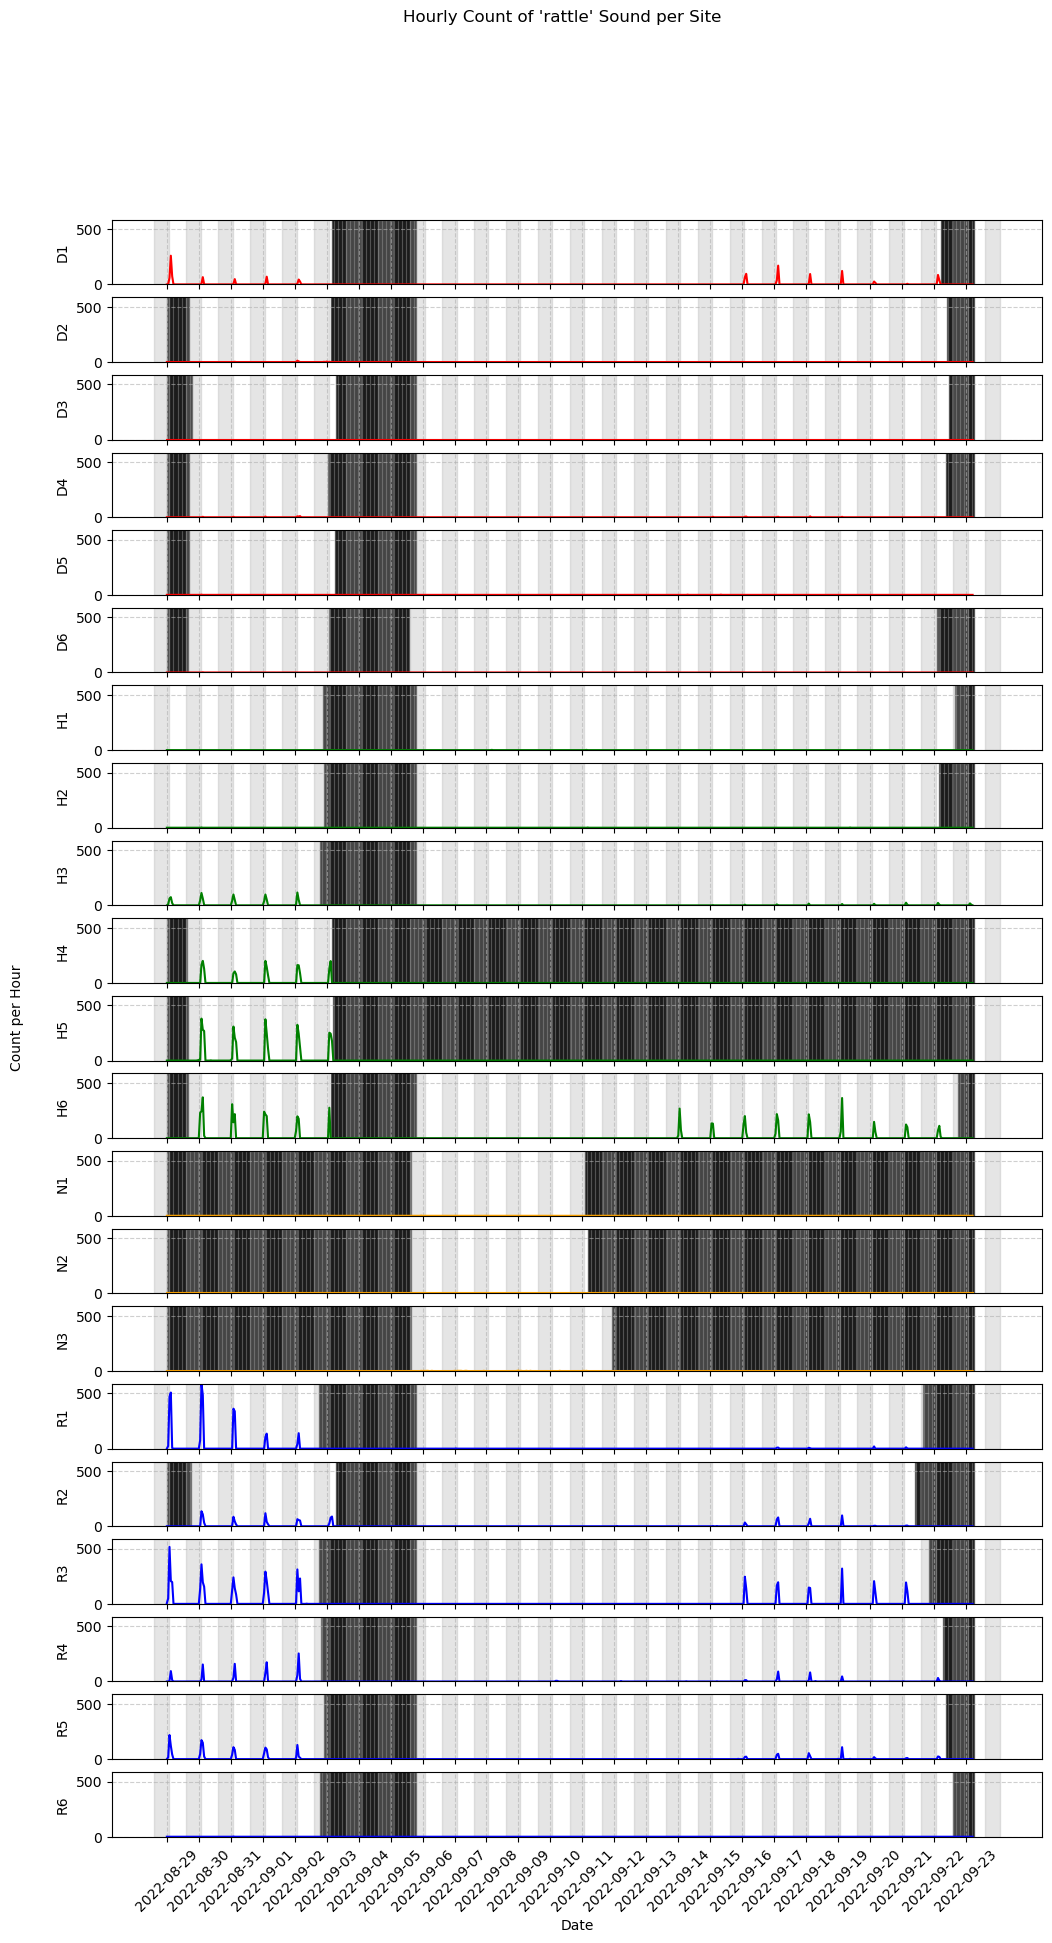

In [90]:
# Suppress warnings
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Get unique sites from file_list_df to ensure all are included
all_sites = file_list_df['site_name'].unique()

# Extract 'site_name', 'date', and 'time' from 'filename'
filtered_df['site_name'] = filtered_df['filename'].str[14:16]
filtered_df['date'] = filtered_df['filename'].str[17:25]
filtered_df['time'] = filtered_df['filename'].str[26:32]

# Convert 'date' and 'time' to datetime and extract hour
filtered_df['datetime'] = pd.to_datetime(filtered_df['date'] + filtered_df['time'], format='%Y%m%d%H%M%S')
filtered_df['hour'] = filtered_df['datetime'].dt.floor('h')

# Group by 'site_name' and 'hour' to get the count of occurrences per hour
hourly_counts = filtered_df.groupby(['site_name', 'hour']).size().reset_index(name='count')

# Multiply each count by the duty cycle
hourly_counts['count'] *= DUTY_CYCLE  

# Define the global time range and create an hourly timeline for all sites
global_start_time = filtered_df['datetime'].min().floor('h')
global_end_time = filtered_df['datetime'].max().ceil('h')
global_hours = pd.date_range(start=global_start_time, end=global_end_time, freq='h')

# Prepare a complete timeline with all hours and sites, filling missing counts with 0
timeline_df = pd.DataFrame([(site, hour) for site in all_sites for hour in global_hours], columns=['site_name', 'hour'])
timeline_df = timeline_df.merge(hourly_counts, on=['site_name', 'hour'], how='left').fillna(0)

# Colour mapping and maximum count for consistent y-axis limits
colour_mapping = {'D': 'red', 'H': 'green', 'N': 'orange', 'R': 'blue'}
max_count = timeline_df['count'].max()

# Get unique dates for sunrise/sunset calculations
unique_dates = pd.to_datetime(timeline_df['hour'].dt.date.unique()).sort_values()

# Extract the date and time portion from the filename, ensuring correct slicing
file_list_df['datetime'] = pd.to_datetime(file_list_df['filename'].str[7:21], format='%Y%m%d_%H%M%S')
file_list_df['hour'] = file_list_df['datetime'].dt.floor('h')
recording_hours = file_list_df.groupby('site_name')['hour'].apply(set).to_dict()  # Dictionary of sets of recording hours per site

# Plotting setup
fig, axs = plt.subplots(len(all_sites), 1, figsize=(12, 1 * len(all_sites)), sharex=True)

for i, site in enumerate(sorted(all_sites)):
    # Filter data for the current site
    site_data = timeline_df[timeline_df['site_name'] == site]
    site_colour = colour_mapping.get(site[0], 'grey')
    
    # Set white background and plot data for the site
    axs[i].set_facecolor("white")
    axs[i].plot(site_data['hour'], site_data['count'], color=site_colour)
    axs[i].set_ylabel(site)
    axs[i].set_ylim(0, max_count)
    axs[i].grid(True, linestyle='--', alpha=0.6)
    
    # Identify missing hours for this site by comparing global hours to recorded hours
    recorded_hours = recording_hours.get(site, set())
    missing_hours = [hour for hour in global_hours if hour not in recorded_hours]
    
    # Apply black shading for each missing hour
    for hour in missing_hours:
        axs[i].axvspan(hour, hour + timedelta(hours=1), color='black', alpha=0.5, clip_on=True)

    # Shading for adjusted night periods
    for date in site_data['hour'].dt.date.unique():
        # Adjusted sunset and sunrise times
        sunset = sun(location.observer, date=date, tzinfo=local_timezone)['sunset'] + timedelta(minutes=30)
        sunrise = sun(location.observer, date=date + timedelta(days=1), tzinfo=local_timezone)['sunrise'] - timedelta(minutes=30)
        
        # Shade from adjusted sunset to adjusted sunrise
        axs[i].axvspan(sunset, sunrise, color='darkgrey', alpha=0.3, clip_on=True)

# Set x-ticks precisely every 24 hours
plt.xticks(pd.date_range(start=global_start_time, end=global_end_time, freq='24h'), rotation=45)

# Set labels and titles
plt.suptitle(f"Hourly Count of '{TARGET_SOUND}' Sound per Site")
plt.xlabel("Date")
fig.text(0.04, 0.5, 'Count per Hour', va='center', rotation='vertical')

plt.show()


am i sure the night is corr3ect??? rattle happens at night not dawn!!
maybe plot for just 3 days or something and get hour markers on axis

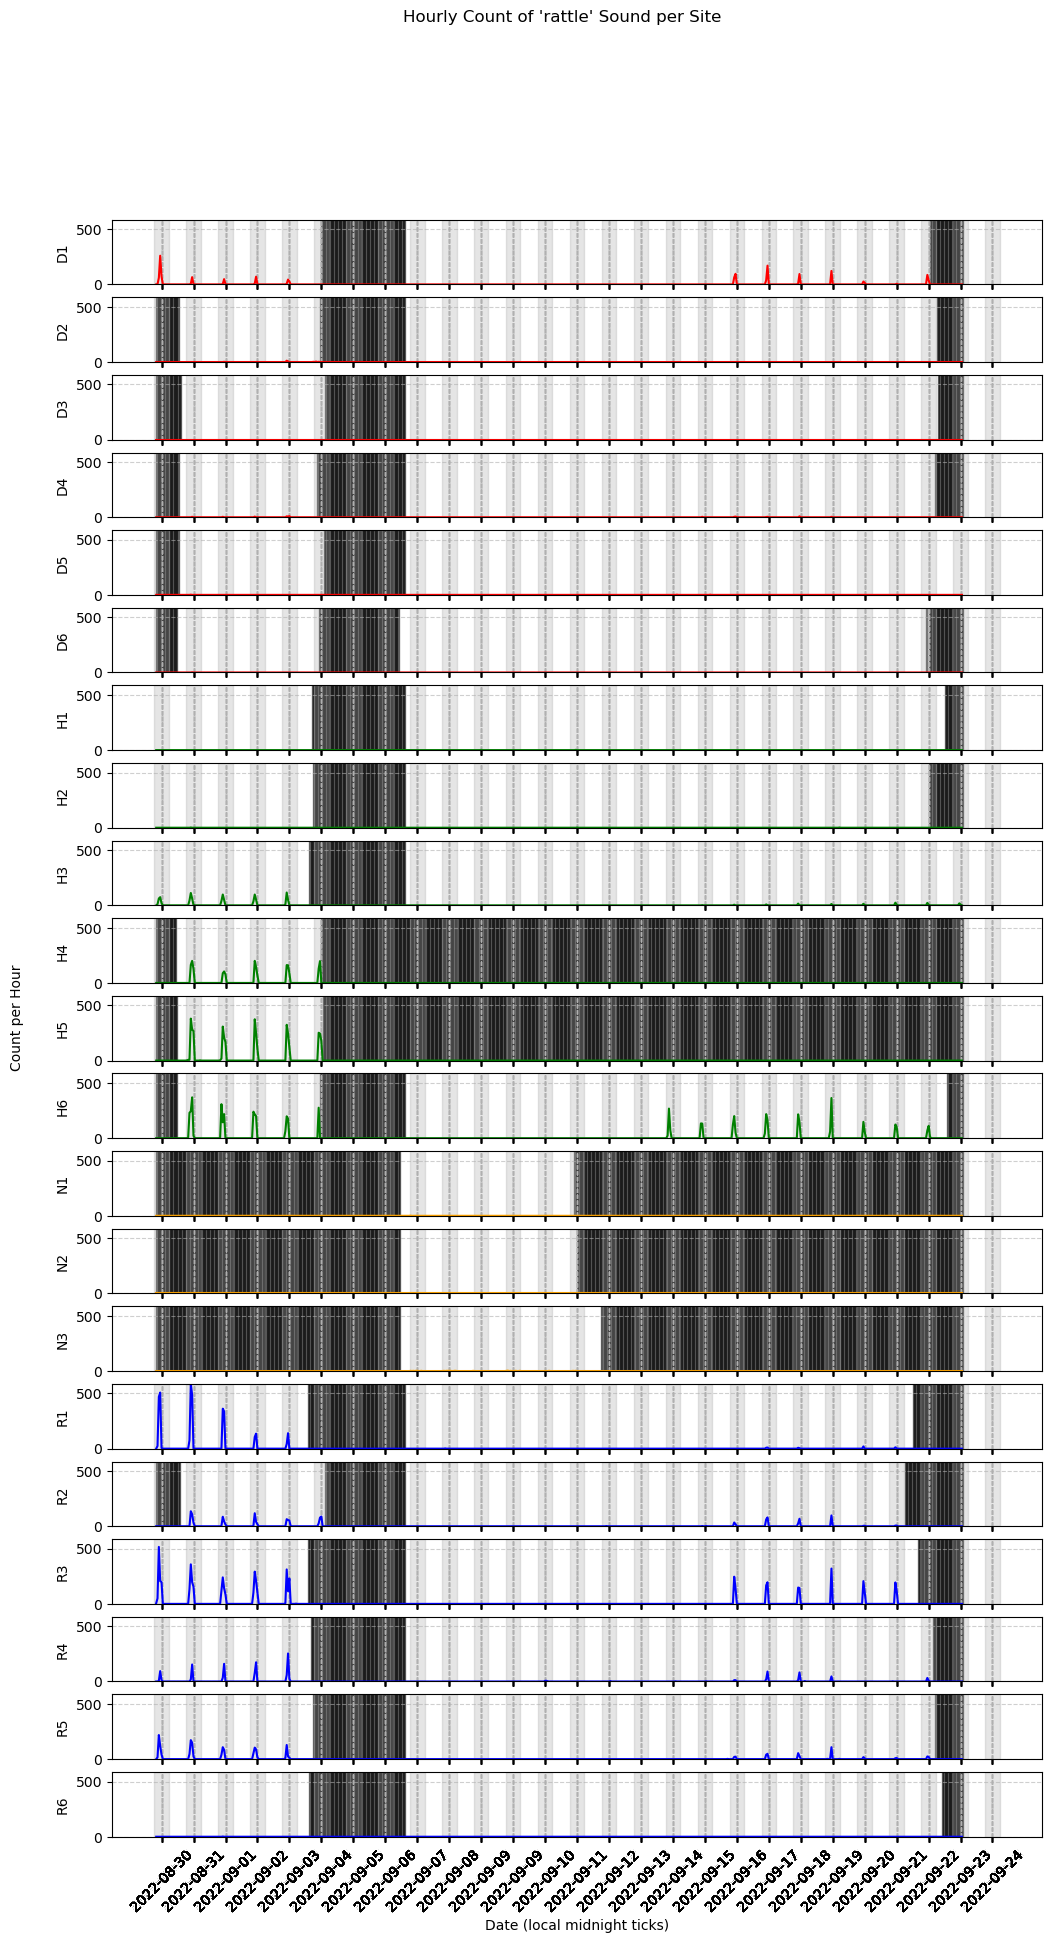

In [104]:
# Suppress warnings
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Get unique sites from file_list_df to ensure all are included
all_sites = file_list_df['site_name'].unique()

# Extract 'site_name', 'date', and 'time' from 'filename'
filtered_df['site_name'] = filtered_df['filename'].str[14:16]
filtered_df['date'] = filtered_df['filename'].str[17:25]
filtered_df['time'] = filtered_df['filename'].str[26:32]

# Convert 'date' and 'time' to datetime and extract hour
filtered_df['datetime'] = pd.to_datetime(filtered_df['date'] + filtered_df['time'], format='%Y%m%d%H%M%S')
filtered_df['hour'] = filtered_df['datetime'].dt.floor('h')

# Group by 'site_name' and 'hour' to get the count of occurrences per hour
hourly_counts = filtered_df.groupby(['site_name', 'hour']).size().reset_index(name='count')

# Multiply each count by the duty cycle
hourly_counts['count'] *= DUTY_CYCLE  

# Define the global time range and create an hourly timeline for all sites
global_start_time = filtered_df['datetime'].min().floor('h')
global_end_time = filtered_df['datetime'].max().ceil('h')
global_hours = pd.date_range(start=global_start_time, end=global_end_time, freq='h')

# Prepare a complete timeline with all hours and sites, filling missing counts with 0
timeline_df = pd.DataFrame([(site, hour) for site in all_sites for hour in global_hours], columns=['site_name', 'hour'])
timeline_df = timeline_df.merge(hourly_counts, on=['site_name', 'hour'], how='left').fillna(0)

# Colour mapping and maximum count for consistent y-axis limits
colour_mapping = {'D': 'red', 'H': 'green', 'N': 'orange', 'R': 'blue'}
max_count = timeline_df['count'].max()

# Extract the date and time portion from the filename, ensuring correct slicing
file_list_df['datetime'] = pd.to_datetime(file_list_df['filename'].str[7:21], format='%Y%m%d_%H%M%S')
file_list_df['hour'] = file_list_df['datetime'].dt.floor('h')
recording_hours = file_list_df.groupby('site_name')['hour'].apply(set).to_dict()  # Dictionary of sets of recording hours per site

# Calculate a list of local midnight times based on sunset and sunrise
local_midnights = []  # List to store calculated local midnights

# Plotting setup
fig, axs = plt.subplots(len(all_sites), 1, figsize=(12, 1 * len(all_sites)), sharex=True)

# Calculate sunset and sunrise times correctly
# Convert sunset and sunrise to naive local times for consistent plotting
for i, site in enumerate(sorted(all_sites)):
    # Filter data for the current site
    site_data = timeline_df[timeline_df['site_name'] == site]
    site_colour = colour_mapping.get(site[0], 'grey')
    
    # Set white background and plot data for the site
    axs[i].set_facecolor("white")
    axs[i].plot(site_data['hour'], site_data['count'], color=site_colour)
    axs[i].set_ylabel(site)
    axs[i].set_ylim(0, max_count)
    axs[i].grid(True, linestyle='--', alpha=0.6)
    
    # Identify missing hours for this site by comparing global hours to recorded hours
    recorded_hours = recording_hours.get(site, set())
    missing_hours = [hour for hour in global_hours if hour not in recorded_hours]
    
    # Apply black shading for each missing hour
    for hour in missing_hours:
        axs[i].axvspan(hour, hour + timedelta(hours=1), color='black', alpha=0.5, clip_on=True)

    # Shading for adjusted night periods and calculating local midnight
    for date in site_data['hour'].dt.date.unique():
        # Adjusted sunset and sunrise times
        sunset = sun(location.observer, date=date, tzinfo=local_timezone)['sunset'] + timedelta(minutes=30)
        sunrise = sun(location.observer, date=date + timedelta(days=1), tzinfo=local_timezone)['sunrise'] - timedelta(minutes=30)

        # Convert to naive times (drop timezone) while keeping in local time
        sunset_naive = sunset.replace(tzinfo=None)
        sunrise_naive = sunrise.replace(tzinfo=None)
        
        # Calculate local midnight as the midpoint between sunset and the next day's sunrise
        local_midnight = sunset_naive + (sunrise_naive - sunset_naive) / 2
        local_midnights.append(local_midnight)  # Store local midnight for x-ticks

        # Shade from naive sunset to naive sunrise
        axs[i].axvspan(sunset_naive, sunrise_naive, color='darkgrey', alpha=0.3, clip_on=True)

# Use the calculated local midnight values for x-ticks
plt.xticks(local_midnights, [midnight.strftime('%Y-%m-%d') for midnight in local_midnights], rotation=45)

# Set labels and titles
plt.suptitle(f"Hourly Count of '{TARGET_SOUND}' Sound per Site")
plt.xlabel("Date (local midnight ticks)")
fig.text(0.04, 0.5, 'Count per Hour', va='center', rotation='vertical')

plt.show()


In [ ]:
FIX weird x axis labels!